# Constant

# Load data

In [246]:
import pandas as pd

data = pd.read_csv("dataset2020.csv")
mapping = {'pe-legit': 0, 'pe-malicious': 1}
data.iloc[:,0].replace(mapping, inplace=True)

X=data.iloc[:,1:].values
Y=data.iloc[:,0].values


# process data

In [247]:
from numpy import array
import numpy as np
from tensorflow.keras.utils import *

feature=array(X)
label=array(Y)
label = np.reshape(label, (label.shape[0], 1))
label = to_categorical(label, num_classes = 2)

arr = []
for i in feature:
  arr.append(np.reshape(i, (2, 243)).tolist())
feature = np.array(arr)

print(label.shape, feature.shape)
print(label)


(49128, 2) (49128, 2, 243)
[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


# Split train-test data

In [248]:
from sklearn.model_selection import train_test_split
X_train ,X_test, Y_train,Y_test = train_test_split(feature, label,test_size=1 / 5, random_state=0)
print(Y_test)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# Create model

In [249]:
!pip install keras-metrics

You should consider upgrading via the 'c:\users\khoi\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [250]:
def f1_score(y_true, y_pred, threshold_shift=0):
    beta = 2

    y_pred = K.clip(y_pred, 0, 1)

    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

In [270]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization
from keras.metrics import *
import keras_metrics as km
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1:]), return_sequences=False, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile( loss="binary_crossentropy",
              optimizer=RMSprop(lr=0.001), 
              metrics=['accuracy', f1_score, Precision(name="precision"), km.recall()])

tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fn


# Train

In [271]:
import time
model.summary()
t1 = time.time()
history = model.fit(x=X_train, y=Y_train,batch_size=36,
                    epochs=50, validation_split = 0.2, shuffle=True)
t2 = time.time()
#  batch_size=100,

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_114 (LSTM)              (None, 64)                78848     
_________________________________________________________________
dropout_88 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_152 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_153 (Dense)            (None, 2)                 258       
_________________________________________________________________
activation_75 (Activation)   (None, 2)                 0         
Total params: 87,426
Trainable params: 87,426
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
874/874 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8393 - f1_score: 0.8393 

KeyboardInterrupt: 

# Test

In [269]:
t3 = time.time()
acc = model.evaluate(X_train, Y_train)
t4 = time.time()
print('Loss: {}'.format(loss))
print('Accuracy: {}'.format(acc))

1229/1229 [==============================] - 2s 1ms/step - loss: 0.0687 - accuracy: 0.9809 - f1_score: 0.9810 - precision: 0.9578 - recall: 0.9631
Loss: 0.1958838403224945
Accuracy: [0.06872732192277908, 0.98094242811203, 0.9809550642967224, 0.9577895998954773, 0.9630950093269348]


#### Report

In [227]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import *

y_pred = model.predict(X_test)
label_pred = np.argmax(y_pred, axis = -1)
label_true = np.argmax(Y_test, axis = -1)



target_name = ['clean', 'malware']
print(classification_report(label_true, label_pred, target_names = target_name))

#confusion matrix map
matrix = confusion_matrix(label_true, label_pred)

print(matrix)

print("\n\n")

print("\n---detail----\n")


print("---precision--- ")
print("macro : ", precision_score(label_true, label_pred, average='macro'))
print("micro : ", precision_score(label_true, label_pred, average='micro'))
print("weighted : ", precision_score(label_true, label_pred, average='weighted'))
print("each class : ", precision_score(label_true, label_pred, average=None))

print("\n---recall--- ")
print("macro : ", recall_score(label_true, label_pred, average='macro'))
print("micro : ", recall_score(label_true, label_pred, average='micro'))
print("weighted : ", recall_score(label_true, label_pred, average='weighted'))
print("each class : ", recall_score(label_true, label_pred, average=None))

print("\n---f1 score--- ")
print("macro : ", f1_score(label_true, label_pred, average='macro'))
print("micro : ", f1_score(label_true, label_pred, average='micro'))
print("weighted : ", f1_score(label_true, label_pred, average='weighted'))
print("each class : ", f1_score(label_true, label_pred, average=None))

print("\n---Acc score--- ")
print(accuracy_score(label_true, label_pred))
print("\n---FPR score--- ")
print(matrix[1][0]/(matrix[1][0]+matrix[1][1]))
print("\n---matrix--- ")
print(matrix)
print("\n---time--- ")
print("train", t2-t1)
print("test", t4-t3)


              precision    recall  f1-score   support

       clean       0.94      0.97      0.96      4900
     malware       0.97      0.94      0.96      4926

    accuracy                           0.96      9826
   macro avg       0.96      0.96      0.96      9826
weighted avg       0.96      0.96      0.96      9826

[[4751  149]
 [ 279 4647]]




---detail----

---precision--- 
macro :  0.9567326234420002
micro :  0.9564420924078975
weighted :  0.9567649046680118
each class :  [0.9445328  0.96893244]

---recall--- 
macro :  0.9564767953466404
micro :  0.9564420924078975
weighted :  0.9564420924078975
each class :  [0.96959184 0.94336175]

---f1 score--- 
macro :  0.9564372123067605
micro :  0.9564420924078975
weighted :  0.9564359922814762
each class :  [0.95689829 0.95597614]

---Acc score--- 
0.9564420924078975

---FPR score--- 
0.05663824604141291

---matrix--- 
[[4751  149]
 [ 279 4647]]

---time--- 
train 246.26221585273743
test 2.5440151691436768


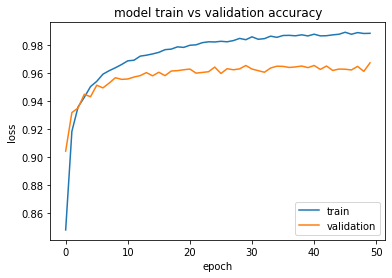

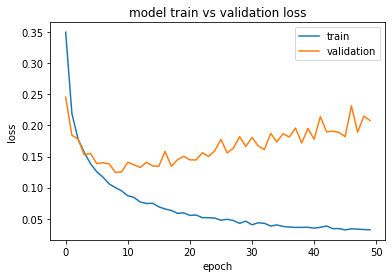

In [88]:
from matplotlib import pyplot

pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'])
pyplot.show()

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'])
pyplot.show()